Experimenting and re-implementing different types of deep learning architecture layers.

In [27]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn

from utils.plots import linear_plot, plot_histograms
from utils.model import trace_module_shapes

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Tracing Module Layers Shapes

Implemented a helper function to quickly trace the intermediate shapes for layers/blocks/models/etc.

In [80]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 32x32x3 -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # 32x32x32 -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # -> 16x16x32
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 16x16x32 -> 16x16x64
            nn.ReLU(),
            nn.MaxPool2d(2)                              # -> 8x8x64
        )
        # After conv_layers, feature map is 8x8 with 64 channels
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                        # N x (64*8*8)
            nn.Linear(64*8*8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)         # output logits for classes
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

x = torch.randn(8, 3, 32, 32)       # batch of 8 RGB images 32×32, C=3
model = SimpleCNN(num_classes=10)

trace_module_shapes(model, x)

Layer                Trainable            Input Shape                    Output Shape
------------------------------------------------------------------------------------------
Conv2d               True                 (8, 3, 32, 32)                 (8, 32, 32, 32)
BatchNorm2d          True                 (8, 32, 32, 32)                (8, 32, 32, 32)
ReLU                 True                 (8, 32, 32, 32)                (8, 32, 32, 32)
Conv2d               True                 (8, 32, 32, 32)                (8, 32, 32, 32)
BatchNorm2d          True                 (8, 32, 32, 32)                (8, 32, 32, 32)
ReLU                 True                 (8, 32, 32, 32)                (8, 32, 32, 32)
MaxPool2d            True                 (8, 32, 32, 32)                (8, 32, 16, 16)
Conv2d               True                 (8, 32, 16, 16)                (8, 64, 16, 16)
ReLU                 True                 (8, 64, 16, 16)                (8, 64, 16, 16)
MaxPool2d            T

#### Batch Normalization (BatchNorm1D / 2D)

Applies Batch Normalization over an input. Batch Normalization is a normalization technique that can be applied at the layer level. Put simply, it **normalizes the inputs to each layer to a learnt representation** likely close to: \\[ \mu = 0.0, \sigma = 1.0 \\] By consequence, all the layer inputs are normalized, and significant outliers are less likely to impact the training process in a negative way. And if they do, their impact will be much lower than without using Batch Normalization. BatchNorm1d is a specific implementation of Batch Normalization in PyTorch, designed for 1-dimensional data. The main idea behind Batch Normalization is to normalize the inputs of each layer in a neural network during training. It **helps us to mitigate the problem of internal covariate shift(the change in the distribution of activations within a neural network as training progresses)**.

* One-dimensional BatchNormalization (nn.BatchNorm1d) applies Batch Normalization over a 2D or 3D input (a batch of 1D inputs with a possible channel dimension).
* Two-dimensional BatchNormalization (nn.BatchNorm2d) applies it over a 4D input (a batch of 2D inputs with a possible channel dimension).

Values sample before: tensor([ 8.6957,  6.3098, 12.1292, 14.8014,  7.4998, 11.2823,  8.3956, 15.3141,
        11.8044, 15.3293]), with max: 23.7570 and min -5.3665
Values sample after: tensor([-0.2881, -0.7377,  0.3110,  0.8437, -0.5830,  0.2800, -0.2946,  0.9363,
         0.2465,  0.9707], grad_fn=<ViewBackward0>), with max: 2.9409 and min -3.1236


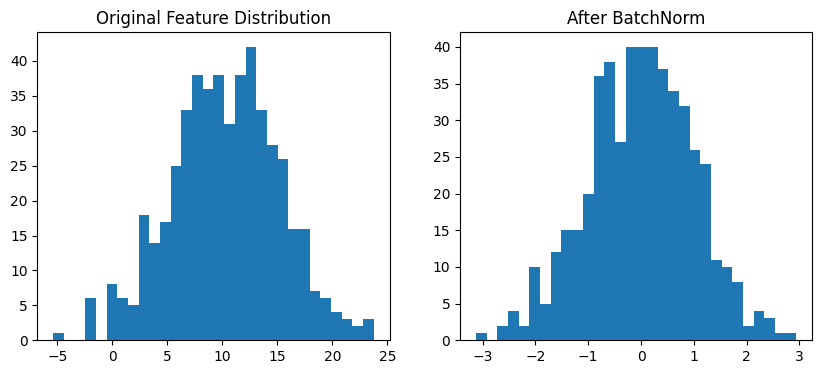

In [38]:
x = torch.randn(100, 5) * 5 + 10
bn = nn.BatchNorm1d(5)
x_bn = bn(x)

print(f"Values sample before: {x[:2].flatten()}, with max: {x.max():.4f} and min {x.min():.4f}")
print(f"Values sample after: {x_bn[:2].flatten()}, with max: {x_bn.max():.4f} and min {x_bn.min():.4f}")

# Plot before and after
plot_histograms(
    [
        {
            "name": "Original Feature Distribution", 
            "values": x.numpy().flatten(),
        },
        {
            "name": "After BatchNorm",
            "values": x_bn.detach().numpy().flatten(),
        }
    ]
)

#### Convolutional Layers(Conv1d/Conv2d/Conv3d)

A convolutional layer `nn.ConvXd` maps an input of shape $(N, C_{in}, …)$ to $(N, C_{out}, …)$, where $C_{out}$ is the number of filters (output channels).

The number of output features in each dimension can be calculated using the following formula $n_{out}$ :

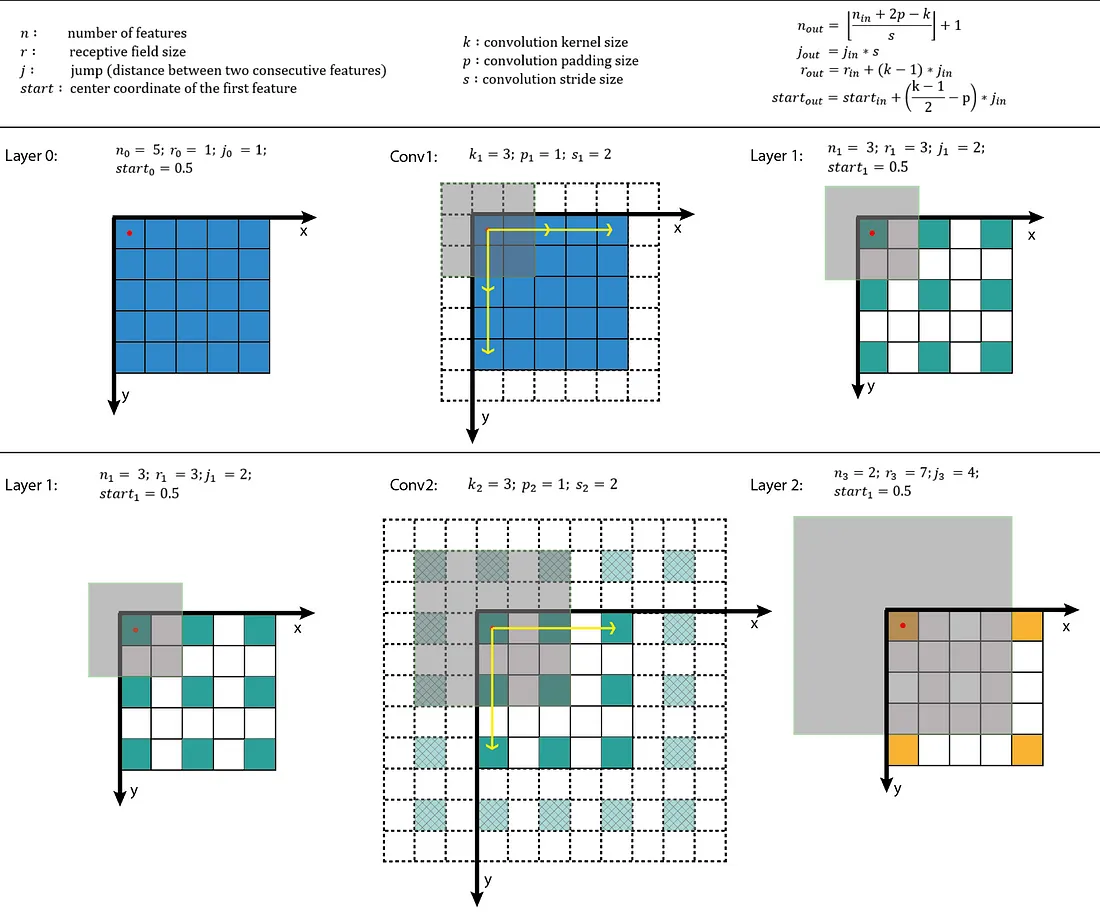

Here $C_{out}=16$ filters produce an output shape `[8,16,32,32]` (same H/W thanks to padding). If instead `stride=2` or larger kernels/padding, the spatial size changes per the formula.

$n_{in} = 32$ <br>
$p = 1$ <br>
$k = 3$ <br>
$s = 1$ <br>

$n_{out}$ = $[(32 + (2*1) - 3)/1]+1 = 32$

In [75]:
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

x = torch.randn(8, 3, 32, 32)       # batch of 8 RGB images 32×32
y = conv(x)

trace_module_shapes(conv, x)

Layer                Trainable            Input Shape                    Output Shape
------------------------------------------------------------------------------------------
Conv2d               True                 (8, 3, 32, 32)                 (8, 16, 32, 32)


$n_{in} = 32$ <br>
$p = 1$ <br>
$k = 3$ <br>
$s = 2$ <br>

$n_{out}$ = $[(32 + (2*1) - 3)/2]+1 = 16$ (Approximating to lower due to Python floor devision `\\`.)

In [76]:
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)

x = torch.randn(8, 3, 32, 32)       # batch of 8 RGB images 32×32
y = conv(x)

trace_module_shapes(conv, x)

Layer                Trainable            Input Shape                    Output Shape
------------------------------------------------------------------------------------------
Conv2d               True                 (8, 3, 32, 32)                 (8, 16, 16, 16)


Therefor, best practices for `Conv` layers:
* Choose `in_channels` equal to the previous layer’s `out_channels` or input shape for the first layer.
* Common kernels are `3x3` or `5x5`.
* When stacking layers, it’s typical to increase (or at least maintain) the number of filters in deeper layers, since deeper layers learn more complex features. For example, one might use 16 filters in layer 1, 32 in layer 2, 64 in layer 3, etc. Deeper layers have more filters to capture larger combinations of patterns. (In practice many designs double channels after a pooling/downsampling step.)
* For GPU efficiency, choose the number of input and output channels to be divisible by 8 (for FP16) or 4 (for TF32) to run efficiently on Tensor Cores [NVIDIA Link Source](https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html#checklist). For the first convolutional layer in most CNNs where the input tensor consists of 3-channel images, padding to 4 channels is sufficient if a stride of 2 is used.


#### Pooling Layers (MaxPool, AvgPool, etc.)

Pooling layers downsample spatial dimensions. For a 2D max-pool `nn.MaxPool2d` with kernel_size and stride, the output height/width follow a formula analogous to convolution. In effect, a 2×2 max-pool with stride 2 halves each spatial dimension (flooring if odd). Pooling operations reduce the size of feature maps by using some function to summarize subregions, such as taking the average or the maximum value. Pooling works by sliding a window across the input and feeding the content of the window to a pooling function. In some sense, pooling works very much like a discrete convolution, but replaces the linear combination described by the kernel with some other function.

The pooling layers generally follow the same formula as `Conv`, just without weights. In most cases, the output size of a pooling layer is affected by:
* $i$:  input.
* $k$: pooling window size.
* $s$: stride.

Thus in some cases, it can be summarized as $Output Size = [(Input Size - Kernel Size)/Stride] + 1$.

In [77]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)

x = torch.randn(8, 3, 32, 32)       # batch of 8 RGB images 32×32
y = pool(x)                         # # if x is [N, C, H, W], now y is [N, C, H/2, W/2]

trace_module_shapes(pool, x)

Layer                Trainable            Input Shape                    Output Shape
------------------------------------------------------------------------------------------
MaxPool2d            False                (8, 3, 32, 32)                 (8, 3, 16, 16)


Experimenting different types:

In [78]:
# 1. Max-Pooling
x = torch.randn(1, 3, 32, 32)

pool = nn.MaxPool2d(kernel_size=2, stride=2)
out = pool(x)
print("MaxPool2d:", out.shape)  # → (1, 3, 16, 16)

# 2. Average pooling: Same structure as max-pooling, but it takes average of each region
pool = nn.AvgPool2d(kernel_size=2, stride=2)
out = pool(x)
print("AvgPool2d:", out.shape)  # → (1, 3, 16, 16)

# 3. Max-Pooling wit ceil_mode=True: Rounds up instead of down if input size isn't divisable by stride
x_odd = torch.randn(1, 3, 33, 33)  # odd-sized input
pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
out = pool(x_odd)
print("MaxPool2d (ceil_mode):", out.shape)  # → (1, 3, 17, 17)

# 4. AdaptiveAvgPool2d(output_size=(7, 7)): Automatically figures out kernel/stride to reach target size (output_size)
pool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
out = pool(x)
print("AdaptiveAvgPool2d (7x7):", out.shape)  # → (1, 3, 7, 7)

# 5. Global Average Pooling (AdaptiveAvgPool2d(1): Averages entire spatial dimension — often used before fully connected layer.
pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
out = pool(x)
print("GlobalAvgPool2d:", out.shape)  # → (1, 3, 1, 1)

# 6. nn.AdaptiveMaxPool2d(output_size=(1, 1)): Global max pooling (instead of average):
pool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
out = pool(x)
print("GlobalMaxPool2d:", out.shape)  # → (1, 3, 1, 1)

# 7. 1D Pooling (e.g. for sequences)
x = torch.randn(1, 3, 100)  # (batch, channels, length)
pool = nn.MaxPool1d(2)
out = pool(x)
print("MaxPool1d:", out.shape)  # → (1, 3, 50)

# 8. 🔹 3D Pooling (e.g. for videos or volumetric data)
x = torch.randn(1, 3, 16, 64, 64)  # (batch, channels, depth, height, width)
pool = nn.MaxPool3d(2)
out = pool(x)
print("MaxPool3d:", out.shape)  # → (1, 3, 8, 32, 32)

MaxPool2d: torch.Size([1, 3, 16, 16])
AvgPool2d: torch.Size([1, 3, 16, 16])
MaxPool2d (ceil_mode): torch.Size([1, 3, 17, 17])
AdaptiveAvgPool2d (7x7): torch.Size([1, 3, 7, 7])
GlobalAvgPool2d: torch.Size([1, 3, 1, 1])
GlobalMaxPool2d: torch.Size([1, 3, 1, 1])
MaxPool1d: torch.Size([1, 3, 50])
MaxPool3d: torch.Size([1, 3, 8, 32, 32])


**Pooling is typically applied after convolution/activation layers to reduce feature map size and induce translation invariance**. For instance, a simple example: input [32×32×3] → Conv (12 filters) → output [32×32×12] → ReLU (same [32×32×12]) → Pool → output [16×16×12]. **The general rule is that pooling only affects H,W as above, not the channel count.**

#### Activation functions (ReLU, Sigmoid, etc.)

They apply elementwise nonlinearity. They do not change the tensor shape: the output tensor has the same shape as input. For example:

```python
relu = nn.ReLU()
z = relu(y)   # y had shape [N, C, H, W]; z also [N, C, H, W]
```

In practice, **activations like ReLU are placed immediately after conv (and usually BatchNorm) to introduce non-linearity**. Using activations between conv layers allows the network to learn complex mappings; without an activation, successive linear layers collapse to one linear mapping.

Practical code can be found in the [activation_functions](./activation_functions.ipynb) notebook.